Configuration for Colab

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !apt install xvfb
    !apt install python-opengl
    !apt install ffmpeg
    !pip install PyVirtualDisplay==3.0
    !pip install gym==0.21.0
    from pyvirtualdisplay import Display

    #Start virtual display
    virtual_display = Display(visible=0, size=(400, 400))
    virtual_display.start()

DQN 

In [2]:
import os
from typing import Dict, List, Tuple

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output

Replay Buffer

In [3]:
class ReplayBuffer:
    '''Replay Buffer that stores transitions in Numpy arrays'''
    def __init__(self, obs_dim, size, batch_size=32):
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0

    def store(self, obs, act, rew, next_obs, done):
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr+1) % self.max_size
        self.size = min(self.size+1, self.max_size)

    def sample_batch(self):
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(obs=self.obs_buf[idxs], next_obs=self.next_obs_buf[idxs], acts=self.acts_buf[idxs], rews=self.rews_buf[idxs], done=self.done_buf[idxs])
    
    def __len__(self):
        return self.size

Network

In [4]:
class Network(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

DQN Agent

Summary of DQN Agent
| Method | Description |
| --- | --- |
| `select_action` | Select an action from input state |
| `step` | Take an action and return the response of the environment |
| `compute_dqn_loss` | Compute the loss of the DQN network |
| `update_model` | Update the parameters of the agent |
| `target_hard_update` | Hard update the target network |
| `train` | Train the agent during num_frames |
| `test` | Test the agent for 1 episode |
| `plot` | Plot the training progress |


In [5]:
class DQNAgent:
    """DQN Agent interacting with environment.
    
    Attribute:
        env (gym.Env): openAI Gym environment
        memory (ReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        epsilon (float): parameter for epsilon greedy policy
        epsilon_decay (float): step size to decrease epsilon
        max_epsilon (float): max value of epsilon
        min_epsilon (float): min value of epsilon
        target_update (int): period for target model's hard update
        gamma (float): discount factor
        dqn (Network): model to train and select actions
        dqn_target (Network): target model to update
        optimizer (torch.optim): optimizer for training dqn
        transition (list): transition information including 
                           state, action, reward, next_state, done
    """
    def __init__(self, env, memory_size, batch_size, target_update, epsilon_decay, seed, max_epsilon=1.0, min_epsilon=0.01, gamma=0.99):
        """Initialization.
        
        Args:
            env (gym.Env): openAI Gym environment
            memory_size (int): length of memory
            batch_size (int): batch size for sampling
            target_update (int): period for target model's hard update
            epsilon_decay (float): step size to decrease epsilon
            lr (float): learning rate
            max_epsilon (float): max value of epsilon
            min_epsilon (float): min value of epsilon
            gamma (float): discount factor
        """
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n

        self.env = env
        self.memory = ReplayBuffer(obs_dim, memory_size, batch_size)
        self.batch_size = batch_size
        self.epsilon = max_epsilon
        self.epsilon_decay = epsilon_decay
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.target_update = target_update
        self.gamma = gamma
        self.seed = seed

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(self.device)
        print(torch.cuda.get_device_name(0))

        self.dqn = Network(obs_dim, action_dim).to(self.device)
        self.dqn_target = Network(obs_dim, action_dim).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()

        self.optimizer = optim.Adam(self.dqn.parameters(), lr=0.0000625, eps=1.5e-4)

        self.transition = list()
        self.is_test = False

    def select_action(self, state):
        """Select an action from the input state."""
        if np.random.uniform() > self.epsilon:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).to(self.device)
                action = self.dqn(state_tensor).argmax()
                action = action.detach().cpu().numpy()
        else:
            action = self.env.action_space.sample()

        if not self.is_test:
            self.transition = [state, action]
        return action
    
    def step(self, action):
        """Take an action and return the response of the env."""
        next_state, reward, terminated, truncated, _ = self.env.step(action)
        done = terminated or truncated
        if not self.is_test:
            self.transition += [reward, next_state, done]
            self.memory.store(*self.transition)
        return next_state, reward, done
    
    def update_model(self):
        """Update the model by gradient descent."""
        samples = self.memory.sample_batch()
        loss = self._compute_dqn_loss(samples)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()
    
    def train(self, num_frames, save_path, plotting_interval=200):
        """Train the agent."""
        self.is_test = False

        scores, epsilons, losses = [], [], []
        update_cnt = 0
        state, _ = self.env.reset()
        for frame_idx in range(1, num_frames+1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)
            state = next_state
            # score += reward

            if done:
                state, _ = self.env.reset()
                # scores.append(score)
                # score = 0
            
            if len(self.memory) >= self.batch_size and frame_idx % 4 == 0 and frame_idx > 7500:
                loss = self.update_model()
                losses.append(loss)
                update_cnt += 1

                #Linearly decrease epsilon
                self.epsilon = max(self.epsilon-(self.max_epsilon - self.min_epsilon)*self.epsilon_decay, self.min_epsilon)
                epsilons.append(self.epsilon)

                #Hard update of target network
                if update_cnt % self.target_update == 0:
                    self._target_hard_update()
            
            if frame_idx % 5000 == 0:
                #Evaluate our model
                self.is_test = True
                test_scores = []
                state, _ = self.env.reset()
                for _ in range(1, 500+1):
                    action = self.select_action(state)
                    next_state, reward, done = self.step(action)
                    state = next_state
                    test_scores.append(reward)

                    if done:
                        state, _ = self.env.reset()
                scores.append(np.array(test_scores).mean())
                self.is_test = False

            if frame_idx % plotting_interval == 0:
                self._plot(frame_idx, scores, losses, epsilons)

        self.env.close()
        np.savez(os.path.join(save_path, 'dqn_lunar.npz'), scores=scores, losses=losses, epsilons=epsilons) # save scores, losses, epsilons

    def test(self, video_folder):
        """Test the agent."""
        self.is_test = True

        naive_env = self.env
        self.env = gym.wrappers.RecordVideo(self.env, video_folder=video_folder, episode_trigger=lambda x: True, disable_logger=True)
        scores = []
        for _ in range(5):
            state, _ = self.env.reset(seed=self.seed)
            done = False
            score = 0

            while not done:
                action = self.select_action(state)
                next_state, reward, done = self.step(action)
                state = next_state
                score += reward
            scores.append(score)
        print("score: ", scores)
        self.env.close()

        self.env = naive_env
        scores = np.array(scores)
        np.savez(os.path.join(video_folder, 'dqn_lunar_test.npz'), mean=scores.mean(), std=scores.std()) # save mean score and std score

    def _compute_dqn_loss(self, samples):
        """Return the loss of DQN."""
        states = torch.FloatTensor(samples['obs']).to(self.device)
        actions = torch.LongTensor(samples['acts'].reshape(-1, 1)).to(self.device)
        rewards = torch.FloatTensor(samples['rews'].reshape(-1, 1)).to(self.device)
        next_states = torch.FloatTensor(samples['next_obs']).to(self.device)
        dones = torch.FloatTensor(samples['done'].reshape(-1, 1)).to(self.device)

        curr_q = self.dqn(states).gather(1, actions)
        next_q = self.dqn_target(next_states).max(dim=1, keepdim=True)[0].detach()
        mask = 1 - dones
        target = (rewards + self.gamma * next_q * mask).to(self.device)

        loss = F.smooth_l1_loss(curr_q, target)
        return loss
    
    def _target_hard_update(self):
        """Hard update of target network."""
        self.dqn_target.load_state_dict(self.dqn.state_dict())

    def _plot(self, frame_idx, scores, losses, epsilons):
        """Plot the training progresses."""
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(131)
        plt.title("Frame %s. score: %s" % (frame_idx, np.mean(scores[-10:])))
        plt.plot(scores)
        plt.xlabel('Eval Steps')
        plt.ylabel('Scores')
        plt.subplot(132)
        plt.title("loss")
        plt.plot(losses)
        plt.xlabel('Updates')
        plt.ylabel('Loss')
        plt.subplot(133)
        plt.title("epsilons")
        plt.plot(epsilons)
        plt.xlabel('Frames')
        plt.ylabel('Epsilons')
        plt.show()

Environment

In [6]:
env = gym.make("LunarLander-v2", render_mode="rgb_array", continuous=False, gravity=-10.0, enable_wind=True, wind_power=15.0, turbulence_power=1.5)
# env = gym.make("Acrobot-v1", render_mode="rgb_array")
# env = gym.make("MountainCar-v0", render_mode="rgb_array")

Set Seeds for the runs

In [7]:
seed = 12435

def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

seed_torch(seed)
# env.seed(seed)
np.random.seed(seed)

INITIALIZE THE AGENT

In [8]:
#Parameters
num_frames = 1000000
memory_size = 25000
batch_size = 32
target_update = 100
epsilon_decay = 1/4000
save_path = 'results/'

agent = DQNAgent(env, memory_size, batch_size, target_update, epsilon_decay, seed)

cuda
NVIDIA GeForce GTX 1650


Train the agent

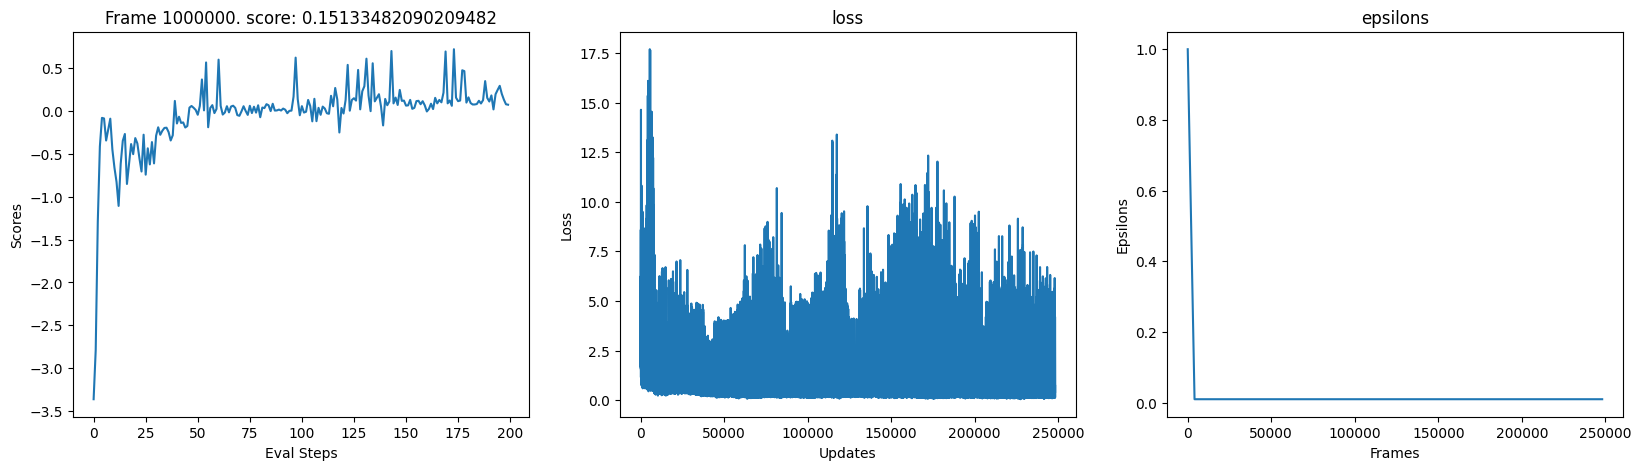

In [9]:
agent.train(num_frames, save_path)

Test
Run agent for 1 episode

In [10]:
video_folder = './videos/dqn_lunar'
agent.test(video_folder)

score:  [61.14241573197065, 204.18783292334962, 201.217647741826, 210.6642521165611, 248.05556270971744]


Render

In [11]:
import base64
import glob
import io
from IPython.display import HTML, display

def ipython_show_video(path):
    """Show a video at `path` within IPython Notebook."""
    if not os.path.isfile(path):
        raise NameError('Cannot access: {}'.format(path))
    video = io.open(path, 'r+b').read()
    encoded = base64.b64encode(video)
    display(HTML(data='''
        <video width="400" height="400" alt="test" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4" />
        </video>'''.format(encoded.decode('ascii'))))

def show_latest_video(video_folder):
    """Show the latest video within the `video_folder`."""
    list_of_files = glob.glob(os.path.join(video_folder, '*.mp4'))
    latest_video = max(list_of_files, key=os.path.getctime)
    ipython_show_video(latest_video)
    return latest_video

latest_video = show_latest_video(video_folder)
print("Played:", latest_video)

Played: ./videos/dqn_lunar\rl-video-episode-4.mp4
